In [154]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [155]:
# laoding the dataset 
df=pd.read_csv("Retail_Sales.csv")
df.head()


,Transaction_ID,Date,Store_Location,Customer_ID,Product_Category,Units_Sold,Revenue (£),Discount_Applied (%),Customer_Age,Loyalty_Score
0,1.0,2024-01-01,Leeds,4958.0,Clothing,7.0,216.0,18.88,69.0,50.25
1,2.0,2024-01-02,London,4189.0,Electronics,19.0,471.0,7.57,46.0,63.63
2,3.0,NaN,Leeds,3087.0,Clothing,9.0,316.0,18.75,68.0,64.21
3,4.0,2024-01-04,Manchester,3367.0,Groceries,15.0,137.0,14.45,27.0,67.74
4,5.0,2024-01-05,Manchester,1160.0,NaN,9.0,99.0,29.06,21.0,92.33


In [156]:
# Data Cleaning
# Dropping CUstomer_ID because its not relevant for this analysis
df = df.drop(columns=['Customer_ID'])
df.columns

Index(['Transaction_ID', 'Date', 'Store_Location', 'Product_Category',
       'Units_Sold', 'Revenue (£)', 'Discount_Applied (%)', 'Customer_Age',
       'Loyalty_Score'],
      dtype='object')

In [157]:
#Inspecting data for missing rows
df[['Transaction_ID', 'Date', 'Store_Location', 'Product_Category',
       'Units_Sold', 'Revenue (£)', 'Discount_Applied (%)', 'Customer_Age',
       'Loyalty_Score']].isna().sum()

Transaction_ID          5
Date                    5
Store_Location          5
Product_Category        5
Units_Sold              5
Revenue (£)             5
Discount_Applied (%)    5
Customer_Age            5
Loyalty_Score           5
dtype: int64

In [158]:
# Fill missing Transaction_ID sequentially
df['Transaction_ID'] = df['Transaction_ID'].fillna(pd.Series(df.index + 1, index=df.index))
df['Transaction_ID'].isna().sum() #checking number of missing rows

0

In [159]:
# Handle missing Date by filling with sequential dates
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Date'] = df['Date'].ffill()  # Forward-fill missing dates
df['Date'].isna().sum() #checking number of missing dates


0

In [160]:
# Handle missing Store_Location with 'null'
df['Store_Location'] = df['Store_Location'].fillna('null')
df['Store_Location'].isna().sum() #checking for missing store locations

0

In [161]:
# Handle missing Product_Category with 'null'
df['Product_Category'] = df['Product_Category'].fillna('null')
df['Product_Category'].isna().sum() #checking for missing product categories

0

In [162]:
# Handle missing Units_Sold with median by Product_Category
df['Units_Sold'] = df.groupby('Product_Category')['Units_Sold'].transform(lambda x: x.fillna(x.median()))

In [163]:
# Handling missing Revenue with median by Product_Category
df['Revenue (£)'] = df.groupby('Product_Category')['Revenue (£)'].transform(lambda x: x.fillna(x.median()))


In [164]:
# Handle missing Discount_Applied with 0 (assuming no discount)
df['Discount_Applied (%)'] = df['Discount_Applied (%)'].fillna(0)

In [165]:
# Handle missing Customer_Age with median
df['Customer_Age'] = df['Customer_Age'].fillna(df['Customer_Age'].median())

In [166]:
# Handle missing Loyalty_Score with median
df['Loyalty_Score'] = df['Loyalty_Score'].fillna(df['Loyalty_Score'].median())

In [167]:
# Ensure numerical columns are float
numeric_cols = ['Units_Sold', 'Revenue (£)', 'Discount_Applied (%)', 'Customer_Age', 'Loyalty_Score']
df[numeric_cols] = df[numeric_cols].astype(float)


In [168]:
# Standardize text columns
df['Store_Location'] = df['Store_Location'].str.title()
df['Product_Category'] = df['Product_Category'].str.title()


In [169]:
# Calculate Revenue After Discount
df['Revenue_After_Discount'] = df['Revenue (£)'] * (1 - df['Discount_Applied (%)'] / 100)

In [170]:
# Extract Month for seasonal analysis

df['Date'] = pd.to_datetime(df['Date']) 

df['Month'] = df['Date'].dt.month


In [171]:
# Create Loyalty Category
df['Loyalty_Category'] = pd.cut(df['Loyalty_Score'], bins=[0, 33, 66, 100], labels=['Low', 'Medium', 'High'])

In [172]:
# Save cleaned dataset
df.to_csv('Retail_Sales1_Cleaned.csv', index=False)


In [173]:
#SUMMARY STATISTICS - EXPLORATORY DATA ANALYSIS

In [ ]:
df.describe()

       Transaction_ID                 Date  Units_Sold  Revenue (£)  \
count      100.000000                  100  100.000000   100.000000   
mean        50.500000  2024-02-19 10:48:00   11.130000   267.075000   
min          1.000000  2024-01-01 00:00:00    1.000000    10.000000   
25%         25.750000  2024-01-25 18:00:00    5.750000   168.750000   
50%         50.500000  2024-02-19 12:00:00   12.500000   277.000000   
75%         75.250000  2024-03-14 12:00:00   16.250000   364.750000   
max        100.000000  2024-04-09 00:00:00   19.000000   492.000000   
std         29.011492                  NaN    5.818214   129.632997   

       Discount_Applied (%)  Customer_Age  Loyalty_Score  \
count            100.000000    100.000000     100.000000   
mean              14.302200     42.410000      52.572800   
min                0.000000     18.000000       0.830000   
25%                6.997500     28.000000      32.805000   
50%               14.415000     42.000000      52.200000   


In [175]:
# Goal 1: Best-Selling Products and Seasonal Trends
# Best-Selling Products by Units Sold and Revenue
best_selling_products = df.groupby('Product_Category').agg({
    'Units_Sold': 'sum',
    'Revenue_After_Discount': 'sum'
}).reset_index()
print("\nBest-Selling Products:")
print(best_selling_products)


Best-Selling Products:
  Product_Category  Units_Sold  Revenue_After_Discount
0         Clothing       479.0               9358.8999
1      Electronics       376.0               7862.9714
2        Groceries       210.0               4251.8340
3             Null        48.0               1436.7530


In [176]:
# Seasonal Trends (Revenue by Month and Product Category)
seasonal_trends = df.groupby(['Month', 'Product_Category'])['Revenue_After_Discount'].sum().unstack().fillna(0)
print("\nSeasonal Trends (Revenue by Month and Product):")
print(seasonal_trends)


Seasonal Trends (Revenue by Month and Product):
Product_Category   Clothing  Electronics  Groceries      Null
Month                                                        
1                 3506.6567    2956.4993   540.5563  755.3574
2                 3082.4226    2647.6176   312.2596  189.3956
3                 1411.1765    1729.6887  3399.0181  492.0000
4                 1358.6441     529.1658     0.0000    0.0000


<Figure size 1200x600 with 0 Axes>

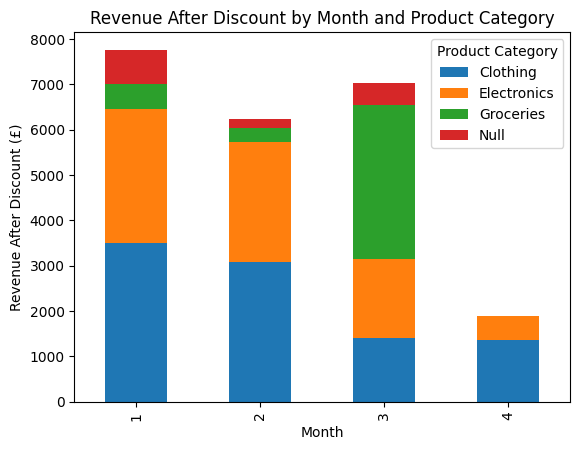

<Figure size 640x480 with 0 Axes>

In [177]:
# Plot Seasonal Trends
plt.figure(figsize=(12, 6))
seasonal_trends.plot(kind='bar', stacked=True)
plt.title('Revenue After Discount by Month and Product Category')
plt.xlabel('Month')
plt.ylabel('Revenue After Discount (£)')
plt.legend(title='Product Category')
plt.show()
plt.tight_layout()
plt.savefig('seasonal_trends.png')


In [178]:
# Goal 2: Impact of Discounts on Revenue
# Correlation between Discount and Revenue After Discount
correlation = df['Discount_Applied (%)'].corr(df['Revenue_After_Discount'])
print(f"\nCorrelation between Discount and Revenue After Discount: {correlation:.2f}")



Correlation between Discount and Revenue After Discount: -0.23


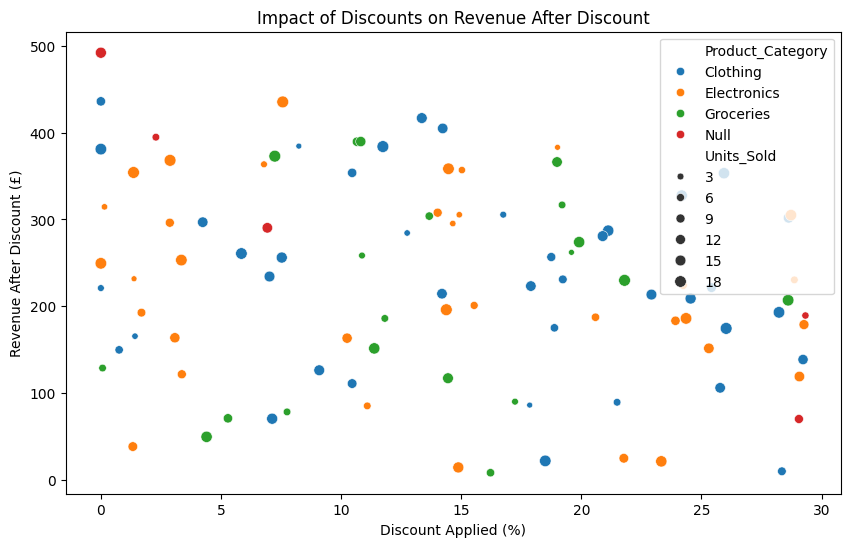

In [179]:
# Scatter Plot of Discount vs. Revenue After Discount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Discount_Applied (%)', y='Revenue_After_Discount', hue='Product_Category', size='Units_Sold')
plt.title('Impact of Discounts on Revenue After Discount')
plt.xlabel('Discount Applied (%)')
plt.ylabel('Revenue After Discount (£)')
plt.show()
plt.tight_layout()
plt.savefig('discount_impact.png')
plt.close()

In [180]:
# Discount Impact by Product Category
discount_impact = df.groupby('Product_Category').agg({
    'Discount_Applied (%)': 'mean',
    'Revenue_After_Discount': 'sum',
    'Units_Sold': 'sum'
}).reset_index()
print("\nDiscount Impact by Product Category:")
print(discount_impact)


Discount Impact by Product Category:
  Product_Category  Discount_Applied (%)  Revenue_After_Discount  Units_Sold
0         Clothing             15.477500               9358.8999       479.0
1      Electronics             13.529429               7862.9714       376.0
2        Groceries             13.499000               4251.8340       210.0
3             Null             13.522000               1436.7530        48.0


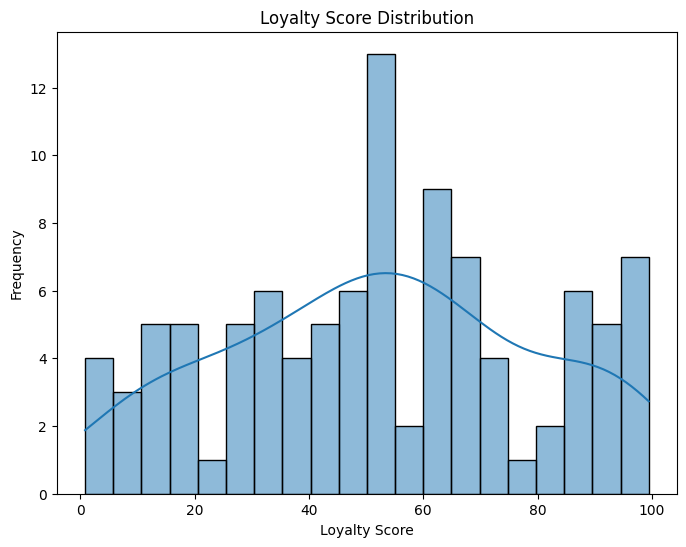

In [181]:
# Goal 3: Customer Loyalty Trends and Purchase Patterns
# Loyalty Score Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Loyalty_Score'], bins=20, kde=True)
plt.title('Loyalty Score Distribution')
plt.xlabel('Loyalty Score')
plt.ylabel('Frequency')
plt.show()
plt.tight_layout()
plt.savefig('loyalty_distribution.png')
plt.close()

In [182]:
# Purchase Patterns by Loyalty Category and Product
purchase_patterns = df.groupby(
    ['Loyalty_Category', 'Product_Category'], observed=True
).agg({
    'Units_Sold': 'sum',
    'Revenue_After_Discount': 'sum'
 }).reset_index()


print("\nPurchase Patterns by Loyalty Category and Product:")
print(purchase_patterns)


Purchase Patterns by Loyalty Category and Product:
   Loyalty_Category Product_Category  Units_Sold  Revenue_After_Discount
0               Low         Clothing        89.0               1464.9261
1               Low      Electronics        93.0               2559.1476
2               Low        Groceries        60.0               1268.6667
3               Low             Null        25.0               1076.1440
4            Medium         Clothing       246.0               4522.9596
5            Medium      Electronics       154.0               2264.7231
6            Medium        Groceries       115.0               2373.9192
7              High         Clothing       144.0               3371.0142
8              High      Electronics       129.0               3039.1007
9              High        Groceries        35.0                609.2481
10             High             Null        23.0                360.6090


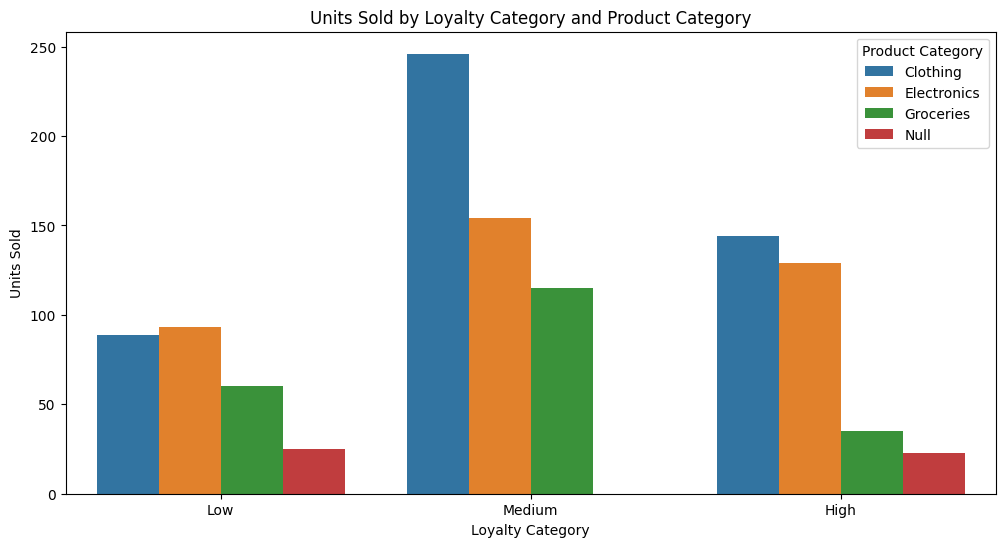

In [183]:
# Plot Purchase Patterns
plt.figure(figsize=(12, 6))
sns.barplot(data=purchase_patterns, x='Loyalty_Category', y='Units_Sold', hue='Product_Category')
plt.title('Units Sold by Loyalty Category and Product Category')
plt.xlabel('Loyalty Category')
plt.ylabel('Units Sold')
plt.legend(title='Product Category')
plt.show()
plt.tight_layout()
plt.savefig('purchase_patterns.png')
plt.close()